<a href="https://colab.research.google.com/github/deebuls/devblog/blob/main/posts/notebooks/2024-01-09-uncertain-data-type-python-bayes-rule-ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Uncertain Data types - Sampling based Bayes-Laplace Rule"

- toc: true
- branch: master
- comments: false
- author: Deebul Nair
- image: images/sampling_bayes_laplace_rule.png
- date: 2023-01-09
- categories: [coding, uncertainty]

# Uncertain Data Types

Uncertain data types play a crucial role in robotics by addressing uncertainties in sensor measurements. For instance, in robotic localization, sensors may provide imprecise information about the robot's position. The advantage lies in using probabilistic models to represent this uncertainty. Methodologies like Bayesian filtering help integrate sensor data and estimate the robot's position more accurately. In software development for robotics, uncertainty-aware algorithms enhance navigation and mapping. Applications include autonomous vehicles, where uncertain data types improve decision-making in dynamic environments. However, challenges arise in developing efficient algorithms due to the computational demands of handling uncertainty in real-time robotic systems.

Efforts to create uncertain data types span various programming languages, each with its approach. In C and C++, developers often implement uncertainty by using custom data structures and libraries. They leverage pointers and structures to represent uncertain values and design algorithms for uncertainty propagation. In Julia, a high-level programming language, the focus is on mathematical simplicity and performance. The language's flexibility allows developers to design custom data types and functions tailored to uncertain data, enhancing computational efficiency. Probabilistic programming languages like Stan and Pyro offer specialized constructs for uncertain data types. These languages enable developers to express uncertainty directly in their models, simplifying the incorporation of probabilistic reasoning. Overall, efforts in uncertain data types reflect the diverse strategies employed across languages, ranging from low-level control in C and C++ to high-level expressiveness in Julia and specialized support in probabilistic programming languages.

In paper [Uncertain<t>]( https://www.microsoft.com/en-us/research/wp-content/uploads/2016/06/uncertaint-toppicks-magazine-copy-15-1.pdf) they developed a datatype called Uncertain<t> in C# language .
For years I was thinking of implementing something similar in python but was missing some motivation. Recently I came accross another hardware level library developed by a company called [Signaloid]( https://signaloid.com/) doing the same in C and C++ language. Since their sample code were available in [github](https://github.com/signaloid/Signaloid-Demo-General-CXX), I got a motivation to write the pending python library.


In [106]:
import scipy.stats as stats
import numpy as np
from scipy.integrate import trapz
import sys
EPSILON = sys.float_info.epsilon
NUM_SAMPLES = 1000


In [73]:
class uDoubleGaussDist:
    """
    Custom datatype replicating double datatype with mathematical operators.

    Attributes:
    - value (float): The value stored in the uDoubleGaussDist.

    Methods:
    - __init__(self, value: float): Initializes the uDoubleGaussDist with a specified value.
    - __add__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines addition operation for uDoubleGaussDist.
    - __sub__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines subtraction operation for uDoubleGaussDist.
    - __mul__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines multiplication operation for uDoubleGaussDist.
    - __truediv__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines true division operation for uDoubleGaussDist.
    - __str__(self) -> str: Returns the string representation of the uDoubleGaussDist.
    """

    def __init__(self, value: float, sigma: float = 1e-6):
        """Initialize uDoubleGaussDist with a specified value."""
        self.value = float(value)
        self.sigma = float(sigma)
        self.distirbution = stats.norm(value, sigma)

    def __add__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define addition operation for uDoubleGaussDist."""

        self_samples = self.distirbution.rvs( size=NUM_SAMPLES, random_state=123)
        other_samples = other.distirbution.rvs( size=NUM_SAMPLES, random_state=123)
        loc1, scale1 = stats.norm.fit(self_samples + other_samples)

        return uDoubleGaussDist(loc1, scale1)

    def __sub__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define subtraction operation for uDoubleGaussDist."""
        self_samples = self.distirbution.rvs( size=NUM_SAMPLES, random_state=123)
        other_samples = other.distirbution.rvs( size=NUM_SAMPLES, random_state=123)
        loc1, scale1 = stats.norm.fit(self_samples - other_samples)
        return uDoubleGaussDist(loc1, scale1)

    def __mul__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define multiplication operation for uDoubleGaussDist."""
        self_samples = self.distirbution.rvs( size=NUM_SAMPLES, random_state=123)
        other_samples = other.distirbution.rvs( size=NUM_SAMPLES, random_state=123)
        loc1, scale1 = stats.norm.fit(self_samples * other_samples)
        return uDoubleGaussDist(loc1, scale1)

    def __truediv__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define true division operation for uDoubleGaussDist."""
        if other.value != 0:
            self_samples = self.distirbution.rvs( size=NUM_SAMPLES, random_state=123)
            other_samples = other.distirbution.rvs( size=NUM_SAMPLES, random_state=123)
            loc1, scale1 = stats.norm.fit(self_samples / other_samples)
            return uDoubleGaussDist(loc1, scale1)
        else:
            raise ValueError("Division by zero")

    def __str__(self) -> str:
        """Return the string representation of uDoubleGaussDist."""
        return str(self.value)

# Example usage:
a = uDoubleGaussDist(2.5)
b = uDoubleGaussDist(1.5)

result = a + b
print(result)  # Output: 4.0

result = a - b
print(result)  # Output: 4.0


result = a * b
print(result)  # Output: 4.0


result = a / b
print(result)  # Output: 4.0


4.000000054218146
1.0
3.750000108437568
1.666666654618567


In [47]:
%timeit a+b

1.61 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [48]:
%timeit 2.5+1.5

15.6 ns ± 3.94 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [65]:
sys.float_info.epsilon

2.220446049250313e-16

# Bayes Laplace Rule


In [113]:
def uDoubleBayesLaplace(prior: uDoubleGaussDist, evidence: uDoubleGaussDist) -> uDoubleGaussDist:
    """
    Perform Bayesian inference using Laplace approximation.

    Parameters:
    - prior (uDoubleGaussDist): Prior distribution.
    - evidence (uDoubleGaussDist): Evidence distribution.

    Returns:
    - uDoubleGaussDist: Posterior distribution.

    This function calculates the posterior distribution using Laplace approximation
    based on the provided prior and evidence distributions. It generates samples
    from the posterior distribution and returns a uDoubleGaussDist object representing
    the posterior distribution.

    Example:
    prior = uDoubleGaussDist(2.5, 0.1)
    evidence = uDoubleGaussDist(1.5, 0.2)
    posterior = uDoubleBayesLaplace(prior, evidence)
    """
    min_sample = min(prior.distirbution.ppf(0.01),
                    evidence.distirbution.ppf(0.01),
                    prior.distirbution.ppf(0.99),
                    evidence.distirbution.ppf(0.99))

    max_sample = max(prior.distirbution.ppf(0.01),
                    evidence.distirbution.ppf(0.01),
                    prior.distirbution.ppf(0.99),
                    evidence.distirbution.ppf(0.99))
    #Generate uniform samples in the x axis
    samples = np.linspace(min_sample,max_sample, NUM_SAMPLES)

    #Calculate likelihood for each sample for prior and the evidence
    prior_pdf = prior.distirbution.pdf(samples)+EPSILON #Adding epsilon to avoid zeros for pdf
    evidence_pdf = evidence.distirbution.pdf(samples)+EPSILON

    #Multiplying the likelihoods
    unnormalized_posterior = prior_pdf * evidence_pdf

    #Normalizing the posterior by calculating the area and dividing by the area
    area = trapz(unnormalized_posterior, samples)
    posterior = unnormalized_posterior / area
    print ("Posterior mean ", samples[np.argmax(posterior)])

    #generating samples from pdf
    generated_samples = np.random.choice(samples, size=NUM_SAMPLES, p=posterior/np.sum(posterior))
    print ("Calculated Posterior mean ", np.mean(generated_samples))

    return uDoubleGaussDist(np.mean(generated_samples), np.std(generated_samples))


prior = uDoubleGaussDist(2.5,0.1)
evidence = uDoubleGaussDist(1.5,0.2)
posterior = uDoubleBayesLaplace(prior, evidence)

Posterior mean  2.2992357760285844
Calculated Posterior mean  2.3000294910807897


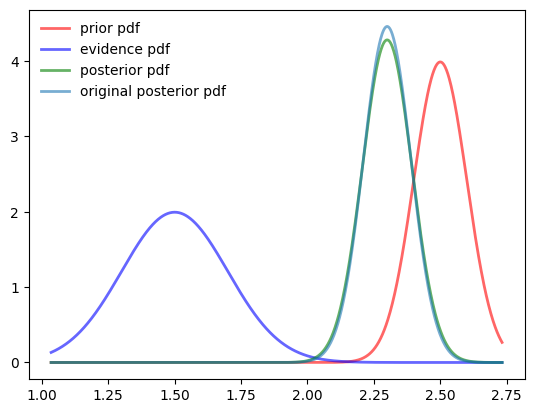

In [114]:
def plotuDoubleBayesLaplace(prior, evidence, posterior):

  fig, ax = plt.subplots(1, 1)
  min_sample = min(prior.distirbution.ppf(0.01),
                   evidence.distirbution.ppf(0.01),
                   prior.distirbution.ppf(0.99),
                   evidence.distirbution.ppf(0.99))

  max_sample = max(prior.distirbution.ppf(0.01),
                   evidence.distirbution.ppf(0.01),
                   prior.distirbution.ppf(0.99),
                   evidence.distirbution.ppf(0.99))

  samples = np.linspace(min_sample,max_sample, NUM_SAMPLES)
  prior_pdf = prior.distirbution.pdf(samples)+EPSILON #Adding epsilon to avoid zeros for pdf

  evidence_pdf = evidence.distirbution.pdf(samples)+EPSILON

  posterior_pdf = posterior.distirbution.pdf(samples)+EPSILON

  unnormalized_posterior = prior_pdf * evidence_pdf

  area = trapz(unnormalized_posterior, samples)
  original_posterior = unnormalized_posterior / area


  ax.plot(samples, prior_pdf,
        'r-', lw=2, alpha=0.6, label='prior pdf')

  ax.plot(samples, evidence_pdf,
        'b-', lw=2, alpha=0.6, label='evidence pdf')


  ax.plot(samples,  posterior_pdf,
        'g-', lw=2, alpha=0.6, label='posterior pdf')

  ax.plot(samples,  original_posterior,
        '-', lw=2, alpha=0.6, label='original posterior pdf')

  ax.legend(loc='best', frameon=False)
  # Save files in pdf and eps format
  plt.savefig("sampling_bayes_laplace_rule.png", dpi=150)

plotuDoubleBayesLaplace(prior, evidence, posterior)


### Corner Case

Need things to improve.

1. When the sigma is very low as 1e-6 .
  * PDF values become zero at all places expect for the
2. When the values are very far apart like 1 and 1000


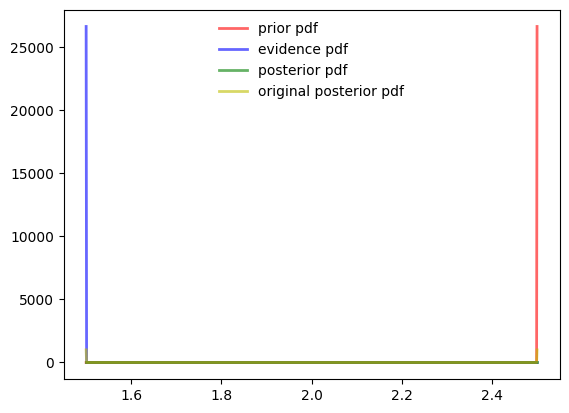

In [80]:

prior = uDoubleGaussDist(2.5)
evidence = uDoubleGaussDist(1.5)
posterior = uDoubleBayesLaplace(prior, evidence)

plotuDoubleBayesLaplace(prior, evidence, posterior)


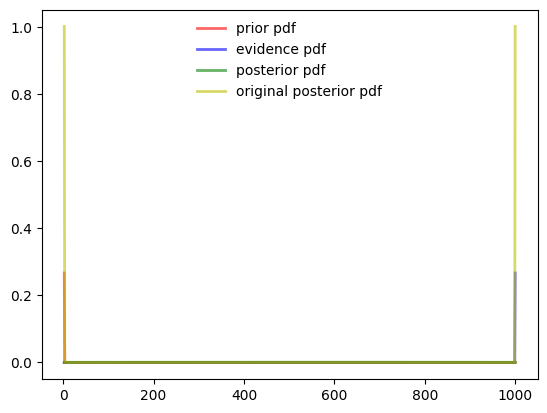

In [82]:

prior = uDoubleGaussDist(2.5, 0.1)
evidence = uDoubleGaussDist(1000, 0.1)
posterior = uDoubleBayesLaplace(prior, evidence)

plotuDoubleBayesLaplace(prior, evidence, posterior)


## Possible solutions (Not working)

1. Sample differently for both the prior and the evidence
2. #TODO The estimated posterior and multiplied posterior are differnt .
  * because of the differnt precision the sample generation process is not working
  * Need an alternative to the sample generation from pdf

In [107]:
def uDoubleBayesLaplace(prior, evidence):

  samples = np.sort( np.append(np.linspace(prior.distirbution.ppf(0.01),
                                 prior.distirbution.ppf(0.99), NUM_SAMPLES),
                     np.linspace(evidence.distirbution.ppf(0.01),
                                 evidence.distirbution.ppf(0.99), NUM_SAMPLES) ))

  prior_pdf = prior.distirbution.pdf(samples) #Adding epsilon to avoid zeros for pdf

  evidence_pdf = evidence.distirbution.pdf(samples)

  unnormalized_posterior = prior_pdf * evidence_pdf

  area = trapz(unnormalized_posterior, samples)
  posterior = unnormalized_posterior / area
  print ("Posterior mean ", samples[np.argmax(posterior)])


  #generating samples from pdf
  generated_samples = np.random.choice(np.linspace(min(samples),
                                                   max(samples),
                                                   num=NUM_SAMPLES*2),
                                       size=NUM_SAMPLES*2,
                                       p=posterior/np.sum(posterior))
  print ("Calculated Posterior mean ", np.mean(generated_samples))


  return uDoubleGaussDist(np.mean(generated_samples), np.std(generated_samples))


prior = uDoubleGaussDist(2.5,0.1)
evidence = uDoubleGaussDist(1.5,0.2)
posterior = uDoubleBayesLaplace(prior, evidence)

Posterior mean  2.299966684304196
Calculated Posterior mean  2.041209314588317


In [ ]:
def plotuDoubleBayesLaplace(prior, evidence, posterior):

  fig, ax = plt.subplots(1, 1)
  samples = np.sort( np.append( np.linspace(prior.distirbution.ppf(0.01),
                                 prior.distirbution.ppf(0.99), NUM_SAMPLES),
                     np.linspace(evidence.distirbution.ppf(0.01),
                                 evidence.distirbution.ppf(0.99), NUM_SAMPLES) ))
  prior_pdf = prior.distirbution.pdf(samples) #Adding epsilon to avoid zeros for pdf

  evidence_pdf = evidence.distirbution.pdf(samples)

  unnormalized_posterior = prior_pdf * evidence_pdf

  area = trapz(unnormalized_posterior, samples)
  original_posterior = unnormalized_posterior / area

  posterior_pdf = posterior.distirbution.pdf(samples)

  ax.plot(samples, prior_pdf,
        'r-', lw=2, alpha=0.6, label='prior pdf')

  ax.plot(samples, evidence_pdf,
        'b-', lw=2, alpha=0.6, label='evidence pdf')


  ax.plot(samples,  posterior_pdf,
        'g-', lw=2, alpha=0.6, label='posterior pdf')

  ax.plot(samples,  original_posterior,
        'y-', lw=2, alpha=0.6, label='original posterior pdf')

  ax.legend(loc='best', frameon=False)

plotuDoubleBayesLaplace(prior, evidence, posterior)


# With Unscented Approaches
#TODO
## Using Sigma Points




In [ ]:
class uDoubleGaussDist:
    """
    Custom datatype replicating double datatype with mathematical operators.

    Attributes:
    - value (float): The value stored in the uDoubleGaussDist.

    Methods:
    - __init__(self, value: float): Initializes the uDoubleGaussDist with a specified value.
    - __add__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines addition operation for uDoubleGaussDist.
    - __sub__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines subtraction operation for uDoubleGaussDist.
    - __mul__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines multiplication operation for uDoubleGaussDist.
    - __truediv__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines true division operation for uDoubleGaussDist.
    - __str__(self) -> str: Returns the string representation of the uDoubleGaussDist.
    """

    def __init__(self, value: float, sigma: float = 1e-6):
        """Initialize uDoubleGaussDist with a specified value."""
        self.value = float(value)
        self.sigma = float(sigma)
        self.distirbution = stats.norm(value, sigma)

    def __add__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define addition operation for uDoubleGaussDist."""

        self_samples = self.distirbution.rvs( size=100, random_state=123)
        other_samples = other.distirbution.rvs( size=100, random_state=123)
        loc1, scale1 = stats.norm.fit(self_samples + other_samples)

        return uDoubleGaussDist(loc1, scale1)

    def __sub__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define subtraction operation for uDoubleGaussDist."""
        self_samples = self.distirbution.rvs( size=100, random_state=123)
        other_samples = other.distirbution.rvs( size=100, random_state=123)
        loc1, scale1 = stats.norm.fit(self_samples - other_samples)
        return uDoubleGaussDist(loc1, scale1)

    def __mul__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define multiplication operation for uDoubleGaussDist."""
        self_samples = self.distirbution.rvs( size=100, random_state=123)
        other_samples = other.distirbution.rvs( size=100, random_state=123)
        loc1, scale1 = stats.norm.fit(self_samples * other_samples)
        return uDoubleGaussDist(loc1, scale1)

    def __truediv__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define true division operation for uDoubleGaussDist."""
        if other.value != 0:
            self_samples = self.distirbution.rvs( size=100, random_state=123)
            other_samples = other.distirbution.rvs( size=100, random_state=123)
            loc1, scale1 = stats.norm.fit(self_samples / other_samples)
            return uDoubleGaussDist(loc1, scale1)
        else:
            raise ValueError("Division by zero")

    def __str__(self) -> str:
        """Return the string representation of uDoubleGaussDist."""
        return str(self.value)

# Example usage:
a = uDoubleGaussDist(2.5)
b = uDoubleGaussDist(1.5)

result = a + b
print(result)  # Output: 4.0

result = a - b
print(result)  # Output: 4.0


result = a * b
print(result)  # Output: 4.0


result = a / b
print(result)  # Output: 4.0



# Notes

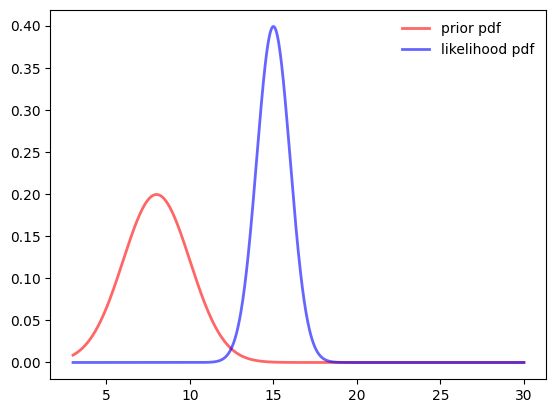

In [1]:
#hide
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.integrate import trapz


mus=[8, 15]
sigmas=[2, 1]



# prior = stats.t(2, loc=mus[0], scale=sigmas[0])
# likelihood = stats.t(2, loc=mus[1], scale=sigmas[1])

# prior = stats.cauchy(loc=mus[0], scale=sigmas[0])
# likelihood = stats.cauchy(loc=mus[1], scale=sigmas[1])

prior = stats.norm(mus[0], sigmas[0])
likelihood = stats.norm(mus[1], sigmas[1])



min_sample = min(prior.ppf(0.01), likelihood.ppf(0.01), prior.ppf(0.99), likelihood.ppf(0.99))
max_sample = max(prior.ppf(0.99), likelihood.ppf(0.99), prior.ppf(0.01), likelihood.ppf(0.01))

samples = np.linspace(3,30, 1000)



fig, ax = plt.subplots(1, 1)

ax.plot(samples, prior.pdf(samples),
       'r-', lw=2, alpha=0.6, label='prior pdf')

ax.plot(samples, likelihood.pdf(samples),
       'b-', lw=2, alpha=0.6, label='likelihood pdf')

ax.legend(loc='best', frameon=False)

In [3]:

prior_pdf = prior.pdf(samples)
np.sum((samples ** 3) * prior_pdf)

708.7380350553744

In [4]:
prior_pdf = prior.pdf(samples)

stats.moment(pdf_, moment = 2) #variance


0.0038653585400454265

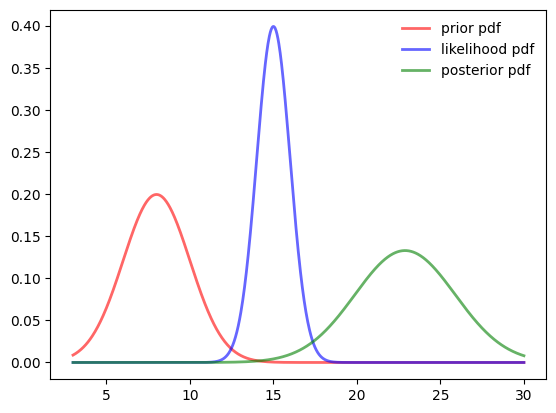

In [6]:

fig, ax = plt.subplots(1, 1)

prior_samples = prior.rvs( size=1000, random_state=123)
likelihood_samples = likelihood.rvs( size=1000, random_state=123)

unnormalized_samples = prior_samples + likelihood_samples

#area = trapz(unnormalized_posterior, samples)

loc1, scale1 = stats.norm.fit(prior_samples + likelihood_samples)
posterior = stats.norm(loc1, scale1)

ax.plot(samples, prior.pdf(samples),
       'r-', lw=2, alpha=0.6, label='prior pdf')

ax.plot(samples, likelihood.pdf(samples),
       'b-', lw=2, alpha=0.6, label='likelihood pdf')


ax.plot(samples,  posterior.pdf(samples),
       'g-', lw=2, alpha=0.6, label='posterior pdf')

ax.legend(loc='best', frameon=False)

In [7]:
print ("prior ", prior.ppf(0.01), (prior.ppf(0.01)+prior.ppf(0.99))/2,  prior.ppf(0.99))
print ("likelihood ", likelihood.ppf(0.01), (likelihood.ppf(0.01)+likelihood.ppf(0.99))/2,  likelihood.ppf(0.99))
print ("posterior ", posterior.ppf(0.01), (posterior.ppf(0.01)+posterior.ppf(0.99))/2,  posterior.ppf(0.99), loc1)
lower_sum =  prior.ppf(0.01)+likelihood.ppf(0.01)
upper_sum =   prior.ppf(0.99)+likelihood.ppf(0.99)
print ("posterior est ",  lower_sum, (lower_sum+upper_sum)/2,  upper_sum, loc1)


prior  3.3473042519183185 8.0 12.652695748081682
likelihood  12.673652125959158 15.0 17.32634787404084
posterior  15.896767710955256 22.88130759175763 29.865847472560002 22.88130759175763
posterior est  16.020956377877475 23.0 29.979043622122525 22.88130759175763


### Bayes

<ipython-input-62-cf338facdf79>:34: RuntimeWarning: invalid value encountered in divide
  posterior = unnormalized_posterior / area


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


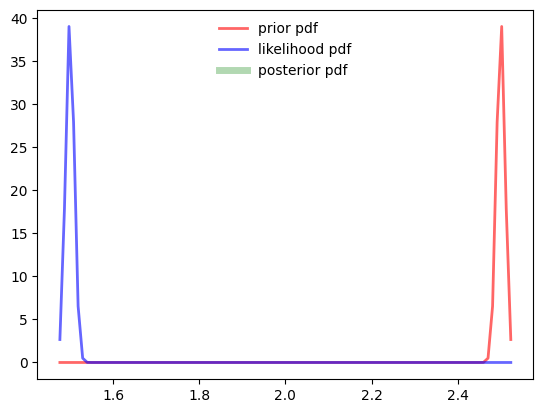

In [62]:
mus=[2.5, 1.5]
sigmas=[1e-2, 1e-2]



# prior = stats.t(2, loc=mus[0], scale=sigmas[0])
# likelihood = stats.t(2, loc=mus[1], scale=sigmas[1])

# prior = stats.cauchy(loc=mus[0], scale=sigmas[0])
# likelihood = stats.cauchy(loc=mus[1], scale=sigmas[1])

prior = stats.norm(mus[0], sigmas[0])
likelihood = stats.norm(mus[1], sigmas[1])



min_sample = min(prior.ppf(0.01), likelihood.ppf(0.01), prior.ppf(0.99), likelihood.ppf(0.99))
max_sample = max(prior.ppf(0.99), likelihood.ppf(0.99), prior.ppf(0.01), likelihood.ppf(0.01))

samples = np.linspace(min_sample,max_sample, 100)




fig, ax = plt.subplots(1, 1)

prior_pdf = prior.pdf(samples)
likelihood_pdf = likelihood.pdf(samples)

unnormalized_posterior = prior_pdf * likelihood_pdf

area = trapz(unnormalized_posterior, samples)

posterior = unnormalized_posterior / area


ax.plot(samples, prior_pdf,
       'r-', lw=2, alpha=0.6, label='prior pdf')

ax.plot(samples, likelihood_pdf,
       'b-', lw=2, alpha=0.6, label='likelihood pdf')


ax.plot(samples, posterior,
       'g-', lw=5, alpha=0.3, label='posterior pdf')

ax.legend(loc='best', frameon=False)
print (posterior)

In [28]:
posterior_lower = samples[np.argmax(prior_pdf>0.01)]
print (posterior_lower)

3.3473042519183185


In [29]:
posterior_upper = samples[-np.argmax(np.flip(prior_pdf)>0.01)]
print (posterior_upper)

12.949071588325708


In [30]:
posterior_mean = samples[np.argmax(prior_pdf)]
print (posterior_mean)

8.006985459292492


In [35]:
posterior_variance = (0.01*(posterior_lower-posterior_mean)**2 + 0.01*(posterior_upper - posterior_mean)**2)/2
posterior_sd = np.sqrt(posterior_variance)
print (posterior_variance)
print (posterior_sd)

0.23068422130569277
0.4802959726103195


In [42]:
prior_samples = prior.rvs(100)
np.std(prior_samples*(1+prior_pdf))

2.1604512762874606

In [44]:
generated_samples = np.random.choice(samples, size=100, p=prior_pdf/np.sum(prior_pdf))
np.std(generated_samples)

2.006476037836466

In [ ]:
class uDoubleGaussDist:
    """
    Custom datatype replicating double datatype with mathematical operators.

    Attributes:
    - value (float): The value stored in the uDoubleGaussDist.

    Methods:
    - __init__(self, value: float): Initializes the uDoubleGaussDist with a specified value.
    - __add__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines addition operation for uDoubleGaussDist.
    - __sub__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines subtraction operation for uDoubleGaussDist.
    - __mul__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines multiplication operation for uDoubleGaussDist.
    - __truediv__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist': Defines true division operation for uDoubleGaussDist.
    - __str__(self) -> str: Returns the string representation of the uDoubleGaussDist.
    """

    def __init__(self, value: float, sigma: float = 1e-6):
        """Initialize uDoubleGaussDist with a specified value."""
        self.value = float(value)
        self.sigma = float(sigma)
        self.distirbution = stats.norm(value, sigma)

    def __add__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define addition operation for uDoubleGaussDist."""

        self_samples = self.distirbution.rvs( size=100, random_state=123)
        other_samples = other.distirbution.rvs( size=100, random_state=123)
        loc1, scale1 = stats.norm.fit(self_samples + other_samples)

        return uDoubleGaussDist(loc1, scale1)

    def __sub__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define subtraction operation for uDoubleGaussDist."""
        self_samples = self.distirbution.rvs( size=100, random_state=123)
        other_samples = other.distirbution.rvs( size=100, random_state=123)
        loc1, scale1 = stats.norm.fit(self_samples - other_samples)
        return uDoubleGaussDist(loc1, scale1)

    def __mul__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define multiplication operation for uDoubleGaussDist."""
        self_samples = self.distirbution.rvs( size=100, random_state=123)
        other_samples = other.distirbution.rvs( size=100, random_state=123)
        loc1, scale1 = stats.norm.fit(self_samples * other_samples)
        return uDoubleGaussDist(loc1, scale1)

    def __truediv__(self, other: 'uDoubleGaussDist') -> 'uDoubleGaussDist':
        """Define true division operation for uDoubleGaussDist."""
        if other.value != 0:
            self_samples = self.distirbution.rvs( size=100, random_state=123)
            other_samples = other.distirbution.rvs( size=100, random_state=123)
            loc1, scale1 = stats.norm.fit(self_samples / other_samples)
            return uDoubleGaussDist(loc1, scale1)
        else:
            raise ValueError("Division by zero")

    def __str__(self) -> str:
        """Return the string representation of uDoubleGaussDist."""
        return str(self.value)

# Example usage:
a = uDoubleGaussDist(2.5)
b = uDoubleGaussDist(1.5)

result = a + b
print(result)  # Output: 4.0

result = a - b
print(result)  # Output: 4.0


result = a * b
print(result)  # Output: 4.0


result = a / b
print(result)  # Output: 4.0
